<a href="https://colab.research.google.com/github/ShriAmogh/Deep_Learning/blob/main/01_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2023-12-10 15:56:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.8MB/s    in 8.2s    

2023-12-10 15:56:13 (19.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os

for dirpath , dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} and {len(filenames)} images in {dirpath}")

There are 2 and 0 images in 10_food_classes_10_percent
There are 10 and 0 images in 10_food_classes_10_percent/test
There are 0 and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 and 250 images in 10_food_classes_10_percent/test/steak
There are 10 and 0 images in 10_food_classes_10_percent/train
There are 0 and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 and 75 images in 10_food

In [3]:
!ls 10_food_classes_10_percent/train

chicken_curry  fried_rice      hamburger  pizza  steak
chicken_wings  grilled_salmon  ice_cream  ramen  sushi


Now process the data for use

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data = train_datagen.flow_from_directory(directory = train_dir , batch_size = BATCH_SIZE, target_size = IMG_SIZE,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(directory = test_dir , batch_size = BATCH_SIZE, target_size = IMG_SIZE,
                                               class_mode = "categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


Now using callbacks
 `Tensorboard callbacks used for tracking experiments

In [4]:
import datetime

def create_tensorflow_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" +  datetime.datetime.now().strftime("%y%m%d-%H%M%S")
  tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir  = log_dir)
  print(f"Saving tensorboard log files to : {log_dir}")
  return tensorflow_callback

In [39]:
#Using tf hub to create models

In [5]:
# Comparing two models

efficient_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"

resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/classification/versions/1"


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
#creating model fn using models url
def creat_model(model_url, num_classes =10):
  '''
  Take a tensorflow hub url and create sequential model with it.

  Args:
  model_url(str): A tensorflow hub feature extraction url
  um_classes(int) : number of output neorons

  Returns:
  A uncompiled keras sequential'''

  #Download pretrained model and save it as keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,  trainable = False,  name ="feature_exttraction_ly",
                                            input_shape = IMG_SIZE +(3,))

  #creating our own model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(10, activation = "softmax", name = "output_layer")
  ])
  return model

In [43]:
resnet_model = creat_model(resnet_url, num_classes = train_data.num_classes)

In [44]:
#compiling
resnet_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [26]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_exttraction_ly (Ke  (None, 1001)              25612201  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25622221 (97.74 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 25612201 (97.70 MB)
_________________________________________________________________


In [45]:
resnet_history = resnet_model.fit(train_data , epochs = 5, steps_per_epoch = len(train_data),
                                 validation_data = test_data, validation_steps = len(test_data),
                                 callbacks = [create_tensorflow_callback(dir_name = "tensorflow_hub", experiment_name= "resnet50v2")])

Saving tensorboard log files to : tensorflow_hub/resnet50v2/231210-123532
Epoch 1/5
24/24 [==============================] - 28s 558ms/step - loss: 2.2969 - accuracy: 0.1453 - val_loss: 2.2873 - val_accuracy: 0.2576
Epoch 2/5
24/24 [==============================] - 11s 465ms/step - loss: 2.2800 - accuracy: 0.3240 - val_loss: 2.2704 - val_accuracy: 0.3768
Epoch 3/5
24/24 [==============================] - 11s 469ms/step - loss: 2.2637 - accuracy: 0.4280 - val_loss: 2.2537 - val_accuracy: 0.5128
Epoch 4/5
24/24 [==============================] - 10s 444ms/step - loss: 2.2476 - accuracy: 0.5200 - val_loss: 2.2373 - val_accuracy: 0.5424
Epoch 5/5
24/24 [==============================] - 11s 467ms/step - loss: 2.2318 - accuracy: 0.5480 - val_loss: 2.2210 - val_accuracy: 0.5632


In [66]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  accuracy = history.history['accuracy']
  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  epoch = range(len(history.history['loss']))

  #plt.subplot(1,2,1)
  plt.figure(figsize = (5,5))
  plt.plot(epoch , loss , label = "traing_loss" )
  plt.plot(epoch , val_loss , label = "val_loss" )
  plt.legend()

  #plt.subplot(1,2,2)
  plt.figure(figsize = (5,5))
  plt.plot(epoch , accuracy , label = "accuracy" )
  plt.plot(epoch , val_accuracy , label = "val_accuracy" )
  plt.legend()



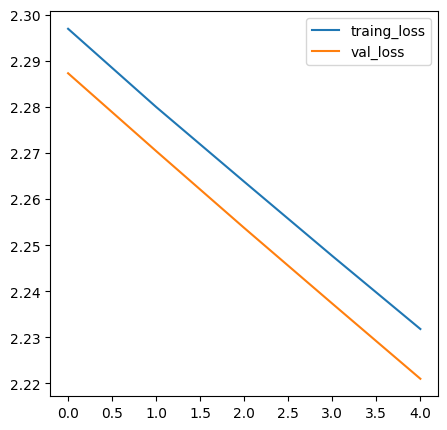

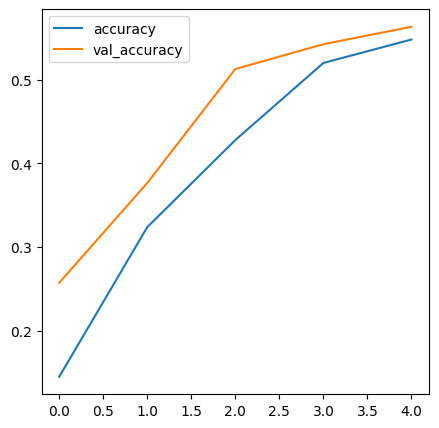

In [67]:
plot_loss_curves(history = resnet_history)

# Now creating n testing efficient model

In [9]:
efficient_model = creat_model(efficient_url, num_classes= train_data.num_classes )

In [11]:
efficient_model.compile(loss = "categorical_crossentropy",
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"])

In [12]:
efficient_history = efficient_model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data),
                                        validation_data = test_data, validation_steps= len(test_data),
                                        callbacks = [create_tensorflow_callback(dir_name = "tensorflow_hub", experiment_name= "efficientb0")])

Saving tensorboard log files to : tensorflow_hub/efficientb0/231210-160501
Epoch 1/5
24/24 [==============================] - 34s 620ms/step - loss: 1.8121 - accuracy: 0.4453 - val_loss: 1.2599 - val_accuracy: 0.7164
Epoch 2/5
24/24 [==============================] - 11s 454ms/step - loss: 1.0417 - accuracy: 0.7760 - val_loss: 0.8518 - val_accuracy: 0.8192
Epoch 3/5
24/24 [==============================] - 10s 413ms/step - loss: 0.7553 - accuracy: 0.8533 - val_loss: 0.6874 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 10s 453ms/step - loss: 0.6080 - accuracy: 0.8707 - val_loss: 0.6019 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 11s 457ms/step - loss: 0.5157 - accuracy: 0.8827 - val_loss: 0.5499 - val_accuracy: 0.8628
